In [1]:
from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig
from gammapy.modeling.models import Models, create_crab_spectral_model
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

In [2]:
from asgardpy.data.dataset_3d import Dataset3DGeneration

In [3]:
log = logging.getLogger("test 3d dataset")

In [4]:
base_dir = "/fefs/aswg/workspace/chaitanya.priyadarshi/"
config_file = base_dir + "analyze_pg1553_full.yaml"
output_dir = base_dir + "real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/joint_fit/"

In [5]:
config = AsgardpyConfig()

In [6]:
config_main = config.read(config_file)

In [7]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename=None, filemode=None, format=None, datefmt=None))
('outdir', '/fefs/aswg/workspace/chaitanya.priyadarshi/real_data/AGN/PG1553/v09x/tailcut84/DL3/interp_irf_en_dep/no_tuning/geff_80/teff_80/20220511_dec931/joint_fit/')
('n_jobs', 1)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.fit: 'fit'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [8]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.fit: 'fit'>]

# Target source information

In [9]:
for c in config_main.target:
    print(c)

('source_name', 'PG1553+113')
('sky_position', SkyCoordConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 238.92934976 deg>, lat=<Angle 11.19010155 deg>))
('use_uniform_position', True)
('models_file', None)
('extended', False)
('components', SkyModelComponent(name='PG1553+113', type='SkyModel', spectral=SpectralModelConfig(model_name='LogParabola', type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-05, unit='cm-2 s-1 TeV-1', error=1.5e-06, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=1.5, unit='GeV', error=0.0, min=0.001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.5, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.01, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.433, alpha_norm=1.0)), spatial=SpatialModelConfig(model_name=None, type=None, parameters=[ModelParams(n

# 3D Datasets informations

In [10]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', io=[InputConfig(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola'), glob_pattern={'events': '*MkTime.fits*', 'edisp': '*eDRM.fits*', 'xml_model': '*out.xml', 'exposure': '*BinnedMap.fits*', 'psf': '*psf.fits*'}), InputConfig(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models'), glob_pattern={'diffuse': 'gll_iem_v07.fits*', 'iso': 'iso_P8R3_SOURCE_V3_*.txt'})], dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['FRONT', 'BACK'], map_selection=[<MapSelectionEnum.counts: 'counts'>, <MapSelectionEnum.exposure: 'exposure'>, <MapSelectionEnum.background: 'background'>, <MapSelectionEnum.psf: 'psf'>, <MapSelectionEnum.edisp: 'edisp'>], obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='iso' value=2021-04-01 00:00:

In [11]:
for cc in config_main.fit_params:
    print(cc)

('fit_range', EnergyRangeConfig(min=<Quantity 100. MeV>, max=<Quantity 1. TeV>))
('backend', <BackendEnum.minuit: 'minuit'>)
('optimize_opts', {})
('covariance_opts', {})
('confidence_opts', {})
('store_trace', True)


In [12]:
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [13]:
analysis

# Prepare for a single 3D Dataset, based on instrument and key_name

In [14]:
instruments_list = config_main.dataset3d.instruments
print(len(instruments_list), "number of 3D dataset information provided")

config_3d_dataset = instruments_list[0]
print(f"Instrument selected is {config_3d_dataset.name}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [15]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['FRONT', 'BACK']


# Run each Dataset3DGeneration step

In [16]:
generate_3d_dataset = Dataset3DGeneration(
    log, config_3d_dataset, config_main, key_names[0]
)

## Initialized variables

In [17]:
print(generate_3d_dataset.instrument_name)

Fermi-LAT


In [18]:
print(generate_3d_dataset.config_3d_dataset_io)

[InputConfig(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola'), glob_pattern={'events': '*MkTime.fits*', 'edisp': '*eDRM.fits*', 'xml_model': '*out.xml', 'exposure': '*BinnedMap.fits*', 'psf': '*psf.fits*'}), InputConfig(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models'), glob_pattern={'diffuse': 'gll_iem_v07.fits*', 'iso': 'iso_P8R3_SOURCE_V3_*.txt'})]


In [19]:
print(generate_3d_dataset.config_3d_dataset_info)

name='Fermi-LAT' key=['FRONT', 'BACK'] map_selection=[<MapSelectionEnum.counts: 'counts'>, <MapSelectionEnum.exposure: 'exposure'>, <MapSelectionEnum.background: 'background'>, <MapSelectionEnum.psf: 'psf'>, <MapSelectionEnum.edisp: 'edisp'>] obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='iso' value=2021-04-01 00:00:00.000>, stop=<Time object: scale='utc' format='iso' value=2022-05-25 00:00:00.000>)]) background=BackgroundConfig(method=None, region_finder_method=None, parameters={}, exclusion={'target_source': True, 'regions': [{'type': 'CircleAnnulusSkyRegion', 'name': 'None', 'position': {'frame': 'icrs', 'lon': '238.92934976 deg', 'lat': '11.19010155 deg'}, 'parameters': {'rad_0': '8 deg', 'rad_1': '30 deg'}}]}) safe_mask=SafeMaskConfig(methods=[], parameters={'min': '0.1 GeV', 'max': '1 TeV'}) on_region=SpatialCircleConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 238.92934976 deg>, lat=<Angle 11.

In [20]:
print(generate_3d_dataset.key_name)

FRONT


In [21]:
print(generate_3d_dataset.config_target)

source_name='PG1553+113' sky_position=SkyCoordConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 238.92934976 deg>, lat=<Angle 11.19010155 deg>) use_uniform_position=True models_file=None extended=False components=SkyModelComponent(name='PG1553+113', type='SkyModel', spectral=SpectralModelConfig(model_name='LogParabola', type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-05, unit='cm-2 s-1 TeV-1', error=1.5e-06, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=1.5, unit='GeV', error=0.0, min=0.001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.5, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.01, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.433, alpha_norm=1.0)), spatial=SpatialModelConfig(model_name=None, type=None, parameters=[ModelParams(name=None, value=None, unit=No

In [22]:
print(generate_3d_dataset.model)

model_name='LogParabola' type='LogParabolaSpectralModel' parameters=[ModelParams(name='amplitude', value=1e-05, unit='cm-2 s-1 TeV-1', error=1.5e-06, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=1.5, unit='GeV', error=0.0, min=0.001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.5, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.01, min=1e-06, max=1.0, frozen=False)] ebl_abs=EBLAbsorptionModel(model_name='dominguez', type='EBLAbsorptionNormSpectralModel', redshift=0.433, alpha_norm=1.0)


In [23]:
print(generate_3d_dataset.exclusion_regions, generate_3d_dataset.target_full_model)

[] None


### First check for the given file list if they are readable or not.

In [24]:
file_list = generate_3d_dataset.read_to_objects(
    generate_3d_dataset.model, 
    generate_3d_dataset.key_name
)

The list of DL3 event files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_MkTime.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_MkTime.fits.gz')]
The list of Detector Response Matrix files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_BACK_LogParabola_eDRM.fits.gz'), PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz')]
The list of XML files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LogParabola_LAT_Analysis_out.xml')]
The list of Exposure Map files for LAT selected: [PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+11

In [25]:
print(file_list)

{'xml_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LogParabola_LAT_Analysis_out.xml'), 'events_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_MkTime.fits.gz'), 'edrm_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz'), 'expmap_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_BinnedMap.fits.gz'), 'psf_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_psf.fits.gz'), 'diff_gal_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models/gll_iem_v07.fits'), 'iso_file': PosixPath('/fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models/iso_P8R3_SOURCE_V3_FRONT_v1.txt')}


In [26]:
for k in file_list.keys():
    print(k, file_list[k])

xml_file /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LogParabola_LAT_Analysis_out.xml
events_file /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_MkTime.fits.gz
edrm_file /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz
expmap_file /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_BinnedMap.fits.gz
psf_file /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_psf.fits.gz
diff_gal_file /fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models/gll_iem_v07.fits
iso_file /fefs/aswg/workspace/lst1-agn-paper/LAT/diffuse_models/iso_P8R3_SOURCE_V3_FRONT_v1.txt


In [27]:
print(generate_3d_dataset.exposure)
print(generate_3d_dataset.exposure.geom)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (141, 141, 42)
	ndim  : 3
	unit  : cm2 s
	dtype : >f4

WcsGeom

	axes       : ['lon', 'lat', 'energy_true']
	shape      : (141, 141, 42)
	ndim       : 3
	frame      : fk5
	projection : AIT
	center     : 238.9 deg, 11.2 deg
	width      : 14.1 deg x 14.1 deg
	wcs ref    : 238.9 deg, 11.2 deg



In [28]:
print(generate_3d_dataset.psf)

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (1, 1, 300, 41)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f8



In [29]:
print(generate_3d_dataset.drmap.info())

Filename: /fefs/aswg/workspace/lst1-agn-paper/LAT/PG1553+113/Analysis1/EBL/LogParabola/PG_1553+113_LAT_Analysis_FRONT_LogParabola_eDRM.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (1, 1, 1)   float32   
  1  GTI           1 BinTableHDU     33   194R x 2C   [D, D]   
  2  EBOUNDS       1 BinTableHDU     38   141R x 3C   [I, 1E, 1E]   
  3  DRM           1 BinTableHDU     29   41R x 6C   ['D', 'D', 'I', 'PI(1)', 'PI(1)', 'PE(41)']   
None


In [30]:
print(generate_3d_dataset.edisp_kernel)

None


In [31]:
print(generate_3d_dataset.diff_gal)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (2880, 1441, 28)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



In [32]:
print(generate_3d_dataset.diff_iso)

SkyModel

  Name                      : fermi-diffuse-iso-FRONT
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    norm                  (frozen):      1.000                   
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         
    value                 (frozen):      1.000       1 / sr      




In [33]:
print(len(generate_3d_dataset.list_sources), "number of sources read from XML file")

11 number of sources read from XML file


In [34]:
for src in generate_3d_dataset.list_sources:
    print(src)

SkyModel

  Name                      : PG1553+113
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      1.500       GeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         


SkyModel

  Name                      : 4FGL J1541.7+1413
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model ty

In [35]:
print("Number of free parameters in the whole list of SkyModels:", len(Models(generate_3d_dataset.list_sources).parameters.free_parameters))

Number of free parameters in the whole list of SkyModels: 19


In [36]:
print("Names of the sources in the whole list of SkyModels:", Models(generate_3d_dataset.list_sources).names)

Names of the sources in the whole list of SkyModels: ['PG1553+113', '4FGL J1541.7+1413', '4FGL J1546.0+0819', '4FGL J1548.3+1456', '4FGL J1550.7+0528', '4FGL J1603.8+1104', '4FGL J1607.0+1550', '4FGL J1608.7+1029', '4FGL J1612.1+1407', 'diffuse-iem', 'fermi-diffuse-iso-FRONT']


In [37]:
print("The SkyModel of the target source is\n", generate_3d_dataset.target_full_model)

The SkyModel of the target source is
 SkyModel

  Name                      : PG1553+113
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      1.500       GeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         




### Start preparing objects to create the counts map

In [38]:
generate_3d_dataset.set_energy_dispersion_matrix()

EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (41, 41)
  ndim  : 2
  unit  : 
  dtype : float32

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 41        
	node type  : edges     
	edges min  : 1.5e+02 MeV
	edges max  : 2.0e+06 MeV
	interp     : log       
 MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 41        
	node type  : edges     
	edges min  : 1.5e+02 MeV
	edges max  : 2.0e+06 MeV
	interp     : log       



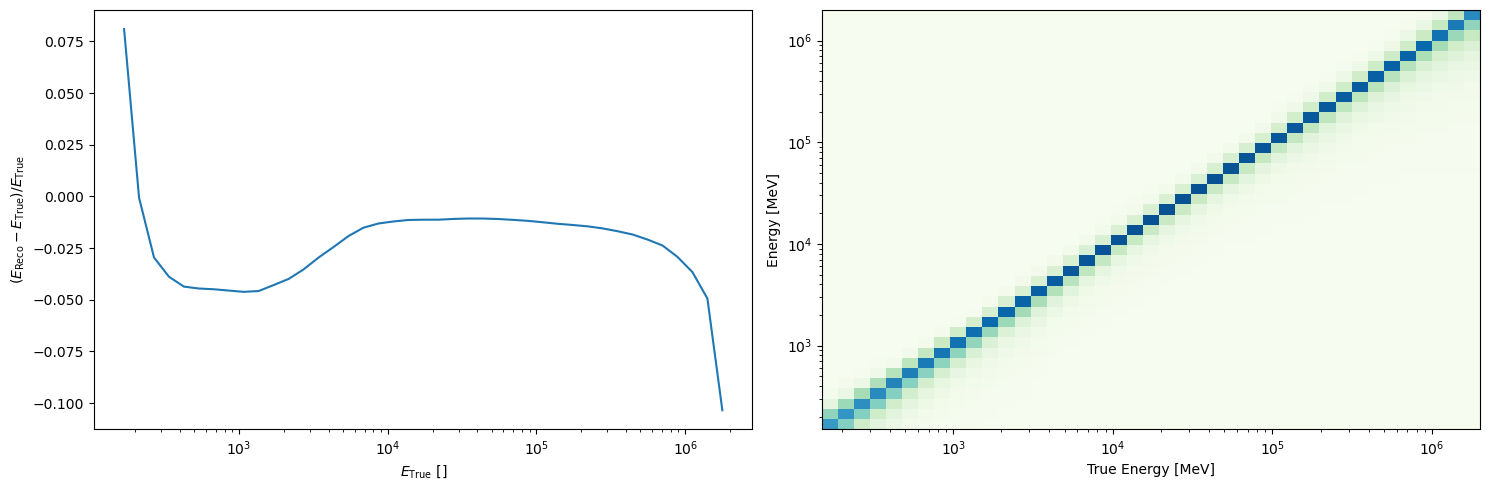

In [39]:
print(generate_3d_dataset.edisp_kernel)
print(generate_3d_dataset.energy_axis, generate_3d_dataset.energy_axis_true)
generate_3d_dataset.edisp_kernel.peek()

In [40]:
generate_3d_dataset.load_events(file_list["events_file"])

### EventList and GTI

In [41]:
# Time interval to select events
print(generate_3d_dataset.config_3d_dataset_info.obs_time.intervals)

[TimeRangeConfig(start=<Time object: scale='utc' format='iso' value=2021-04-01 00:00:00.000>, stop=<Time object: scale='utc' format='iso' value=2022-05-25 00:00:00.000>)]


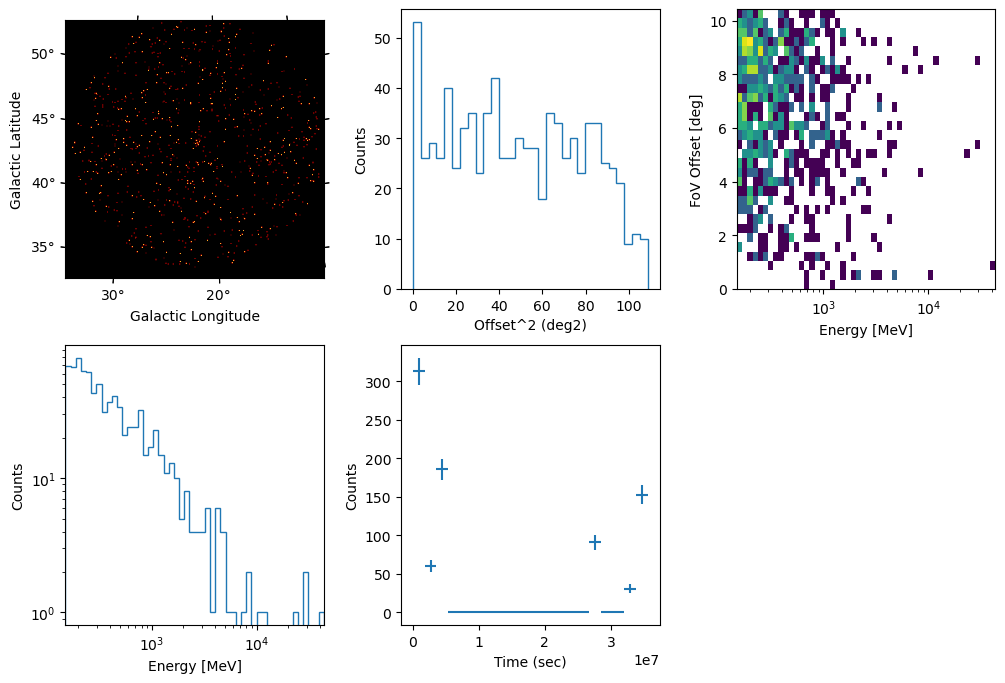

In [42]:
generate_3d_dataset.events.peek()

In [43]:
print(generate_3d_dataset.gti)

GTI info:
- Number of GTIs: 194
- Duration: 878748.0685400963 s
- Start: 639489613.6 s MET
- Start: 2021-04-07T12:01:17.784 (time standard: TT)
- Stop: 675086374.6 s MET
- Stop: 2022-05-24T12:00:38.784 (time standard: TT)



In [44]:
# Source position from the Events file
generate_3d_dataset.get_source_skycoord()
print(generate_3d_dataset.source_pos)

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (238.929, 11.1901)>


## Create the Counts Map

In [45]:
generate_3d_dataset._counts_map()

In [46]:
generate_3d_dataset.counts_map

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (141, 141, 41)
	ndim  : 3
	unit  : 
	dtype : float64

In [47]:
generate_3d_dataset.counts_map.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (141, 141, 41)
	ndim       : 3
	frame      : fk5
	projection : TAN
	center     : 238.9 deg, 11.2 deg
	width      : 14.1 deg x 14.1 deg
	wcs ref    : 238.9 deg, 11.2 deg

In [48]:
generate_3d_dataset.counts_map.data.sum()

544.0

### Exclusion mask

In [49]:
generate_3d_dataset._create_exclusion_mask()

Using the background region from config for exclusion mask
Skipping model fermi-diffuse-iso-FRONT - no spatial component present


PG1553+113 0d00m01.25428523s
4FGL J1541.7+1413 4d33m31.04787186s
4FGL J1546.0+0819 3d43m35.66456158s
4FGL J1548.3+1456 4d09m25.61652147s
4FGL J1550.7+0528 5d50m45.8432288s
4FGL J1603.8+1104 1d59m45.80745452s
4FGL J1607.0+1550 5d24m51.76678001s
4FGL J1608.7+1029 3d15m49.66282584s
4FGL J1612.1+1407 4d57m27.22641296s
Separation of models location from selected center [0d00m01.25428523s 4d33m31.04787186s 3d43m35.66456158s 4d09m25.61652147s
 5d50m45.84322879s 1d59m45.80745452s 5d24m51.76678001s 3d15m49.66282584s
 4d57m27.22641296s 48d06m11.58026544s]


In [50]:
print(generate_3d_dataset.exclusion_mask)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (141, 141, 41)
	ndim  : 3
	unit  : 
	dtype : bool



In [52]:
print(generate_3d_dataset.exclusion_regions)

[]


In [51]:
print(type(generate_3d_dataset.list_sources), len(generate_3d_dataset.list_sources))

<class 'gammapy.modeling.models.core.Models'> 11


### IRF interpolators

In [53]:
generate_3d_dataset._set_edisp_interpolator()

EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (41, 41)
  ndim  : 2
  unit  : 
  dtype : float64



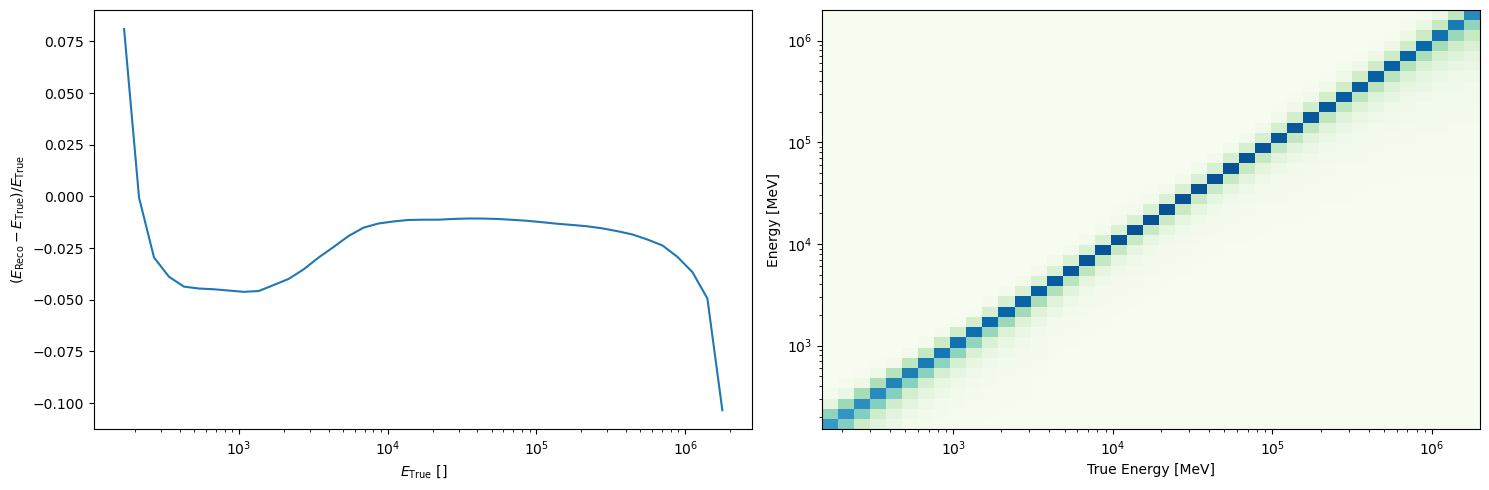

In [55]:
print(generate_3d_dataset.edisp_interp_kernel)
generate_3d_dataset.edisp_interp_kernel.peek()

In [56]:
generate_3d_dataset._set_exposure_interpolator()

In [57]:
print(generate_3d_dataset.exposure_interp)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (141, 141, 41)
	ndim  : 3
	unit  : cm2 s
	dtype : float64



### Diffuse background cutout

In [58]:
print(generate_3d_dataset.list_sources["diffuse-iem"])
generate_3d_dataset._generate_diffuse_background_cutout()

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [59]:
print(generate_3d_dataset.list_sources["diffuse-iem"])

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [60]:
print(generate_3d_dataset.diff_gal_cutout)

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [61]:
print(generate_3d_dataset.diffuse_cutout)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (113, 113, 28)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



### Produce MapDataset

In [62]:
dataset = generate_3d_dataset.generate_dataset()

Using the exclusion mask to create a safe mask


In [63]:
print(dataset)

MapDataset
----------

  Name                            : Fermi-LAT_FRONT 

  Total counts                    : 507 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 2.13e+08 cm2 s
  Exposure max                    : 7.65e+08 cm2 s

  Number of total bins            : 815121 
  Number of fit bins              : 745093 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [65]:
print(generate_3d_dataset.list_sources)

Models

Component 0: SkyModel

  Name                      : PG1553+113
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-05   +/- 1.5e-06 1 / (cm2 s TeV)
    reference             (frozen):      1.500       GeV         
    alpha                         :      1.500   +/-    0.10             
    beta                          :      0.100   +/-    0.01             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.433                   
    lon_0                 (frozen):      0.382       rad         
    lat_0                 (frozen):      0.767       rad         

Component 1: SkyModel

  Name                      : 4FGL J1541.7+1413
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : Poin

In [66]:
# Check assinging models to the dataset

In [67]:
dataset.models = generate_3d_dataset.list_sources

In [68]:
print(dataset)

MapDataset
----------

  Name                            : Fermi-LAT_FRONT 

  Total counts                    : 507 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 157783296933718.47
  Predicted background counts     : nan
  Predicted excess counts         : 157783296925139.69

  Exposure min                    : 2.13e+08 cm2 s
  Exposure max                    : 7.65e+08 cm2 s

  Number of total bins            : 815121 
  Number of fit bins              : 745093 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 315566593848453.44

  Number of models                : 11 
  Number of parameters            : 62
  Number of free parameters       : 19

  Component 0: SkyModel
  
    Name                      : PG1553+113
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       :

In [70]:
dataset.npred_signal(model_name="PG1553+113").data.sum()

32.70512468400929